In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kartik2112/fraud-detection")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fraud-detection' dataset.
Path to dataset files: /kaggle/input/fraud-detection


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
file_path = "/kaggle/input/fraud-detection/fraudTrain.csv"
df = pd.read_csv(file_path)
df.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

#Time Based Feature

In [5]:
# --- Ensure datetime columns ---
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])

In [6]:

df['hour'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

In [7]:
# Time since last transaction (per user)
df = df.sort_values(by=['cc_num','trans_date_trans_time'])
df['time_since_last'] = df.groupby('cc_num')['trans_date_trans_time'].diff().dt.total_seconds().fillna(0)


In [8]:
# Transaction frequency in past 1 hour
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Sort before grouping
df = df.sort_values(by=['cc_num', 'trans_date_trans_time'])

# Define a function to compute rolling counts
def rolling_count_last_hour(group):
    # Set datetime as index for rolling
    group = group.set_index('trans_date_trans_time')
    # Count transactions within the past 1 hour window
    group['trans_count_1h'] = group['cc_num'].rolling('1h').count()
    # Reset index to keep the same structure
    return group.reset_index()

# Apply per user/card group
df = df.groupby('cc_num', group_keys=False).apply(rolling_count_last_hour)

/tmp/ipython-input-425114082.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('cc_num', group_keys=False).apply(rolling_count_last_hour)


In [9]:

# Compute geo distance (user vs merchant)
df['distance_km'] = df.apply(
    lambda row: geodesic((row['lat'], row['long']),
                         (row['merch_lat'], row['merch_long'])).km,
    axis=1
)

# Mark as same_state if within ~50 km
df['same_state'] = (df['distance_km'] < 50).astype(int)


#Amout Based Feature

In [11]:
df['log_amt'] = np.log1p(df['amt'])
# Relative amount (vs customer mean)
df['avg_amt_user'] = df.groupby('cc_num')['amt'].transform('mean')
df['relative_amt'] = df['amt'] / (df['avg_amt_user'] + 1e-5)
# High-value flag (e.g., > 95th percentile)
threshold = df['amt'].quantile(0.95)
df['high_value'] = (df['amt'] > threshold).astype(int)


#DEMOGRAPHIC FEATURES


In [12]:
# Age
df['age'] = df['trans_date_trans_time'].dt.year - df['dob'].dt.year
# Age group
df['age_group'] = pd.cut(df['age'], bins=[0,25,40,60,120], labels=['<25','25-40','40-60','60+'])
# Occupation risk category (simplified example)
risky_jobs = ['student','retired','unemployed']
df['job_risk'] = df['job'].apply(lambda x: 1 if str(x).lower() in risky_jobs else 0)
# City population group
df['city_pop_group'] = pd.cut(df['city_pop'],
                              bins=[0,50000,200000,1000000,1e10],
                              labels=['rural','small_city','city','metro'])

#BEHAVIORAL FEATURES


In [13]:

# Number of unique merchants visited
df['unique_merchants'] = df.groupby('cc_num')['merchant'].transform('nunique')



In [14]:

# Average transaction amount per user
df['user_avg_amt'] = df.groupby('cc_num')['amt'].transform('mean')


In [15]:
df = df.sort_values(by=['cc_num', 'trans_date_trans_time'])

# Define function for rolling 7-day transaction count
def rolling_count_last_7d(group):
    group = group.set_index('trans_date_trans_time')
    group['trans_count_7d'] = group['cc_num'].rolling('7d').count()
    return group.reset_index()

# Apply per cardholder
df = df.groupby('cc_num', group_keys=False).apply(rolling_count_last_7d)


/tmp/ipython-input-3628543483.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('cc_num', group_keys=False).apply(rolling_count_last_7d)


In [16]:
# Merchant diversity (unique merchants / total transactions)
df['merchant_diversity'] = df['unique_merchants'] / df.groupby('cc_num')['merchant'].transform('count')


#CATEGORICAL FEATURES


In [17]:

categorical_cols = ['merchant','category','state','job']
for col in categorical_cols:
    le = LabelEncoder()
    df[col+'_encoded'] = le.fit_transform(df[col].astype(str))
for col in categorical_cols:
    freq_enc = df[col].value_counts().to_dict()
    df[col+'_freq'] = df[col].map(freq_enc)

print("New features created:", df.columns)

New features created: Index(['trans_date_trans_time', 'Unnamed: 0', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'hour', 'day_of_week',
       'is_weekend', 'time_since_last', 'trans_count_1h', 'distance_km',
       'same_state', 'log_amt', 'avg_amt_user', 'relative_amt', 'high_value',
       'age', 'age_group', 'job_risk', 'city_pop_group', 'unique_merchants',
       'user_avg_amt', 'trans_count_7d', 'merchant_diversity',
       'merchant_encoded', 'category_encoded', 'state_encoded', 'job_encoded',
       'merchant_freq', 'category_freq', 'state_freq', 'job_freq'],
      dtype='object')


In [18]:
cols_to_keep = [
    'log_amt', 'hour', 'day_of_week', 'time_since_last',
    'trans_count_1h', 'trans_count_7d',
    'age', 'gender',
    'distance_km', 'same_state', 'city_pop_group',
    'merchant_diversity', 'unique_merchants',
    'merchant_encoded', 'category_encoded', 'state_encoded', 'job_encoded',
    'job_risk', 'avg_amt_user',
    'is_fraud'
]

df_model = df[cols_to_keep]
print(df_model.columns)


Index(['log_amt', 'hour', 'day_of_week', 'time_since_last', 'trans_count_1h',
       'trans_count_7d', 'age', 'gender', 'distance_km', 'same_state',
       'city_pop_group', 'merchant_diversity', 'unique_merchants',
       'merchant_encoded', 'category_encoded', 'state_encoded', 'job_encoded',
       'job_risk', 'avg_amt_user', 'is_fraud'],
      dtype='object')


In [19]:
le = LabelEncoder()
df_model['gender'] = le.fit_transform(df_model['gender'])
df_model['city_pop_group'] = le.fit_transform(df_model['city_pop_group'])

/tmp/ipython-input-3619086601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['gender'] = le.fit_transform(df_model['gender'])
/tmp/ipython-input-3619086601.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['city_pop_group'] = le.fit_transform(df_model['city_pop_group'])


is_fraud
0    1289169
1       7506
Name: count, dtype: int64


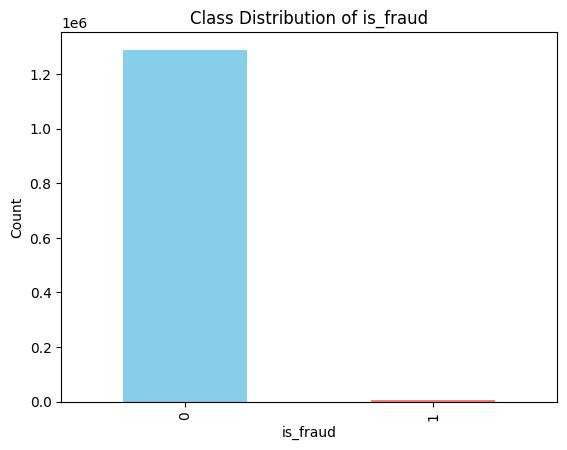

In [20]:
class_counts = df_model['is_fraud'].value_counts()
print(class_counts)
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution of is_fraud')
plt.xlabel('is_fraud')
plt.ylabel('Count')
plt.show()


In [21]:
df_model.head()

,log_amt,hour,day_of_week,time_since_last,trans_count_1h,trans_count_7d,age,gender,distance_km,same_state,city_pop_group,merchant_diversity,unique_merchants,merchant_encoded,category_encoded,state_encoded,job_encoded,job_risk,avg_amt_user,is_fraud
0,2.112635,12,1,0.0,1.0,1.0,33,0,127.629296,0,2,0.378788,575,293,8,50,246,0,56.023366,0
1,3.987872,8,2,71862.0,1.0,2.0,33,0,110.202992,0,2,0.378788,575,43,2,50,246,0,56.023366,0
2,4.419804,8,2,159.0,2.0,3.0,33,0,21.841827,1,2,0.378788,575,399,2,50,246,0,56.023366,0
3,3.577669,12,2,13838.0,1.0,4.0,33,0,87.124420,0,2,0.378788,575,126,7,50,246,0,56.023366,0
4,3.338613,13,2,1952.0,2.0,5.0,33,0,74.352876,0,2,0.378788,575,41,6,50,246,0,56.023366,0


In [22]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 2058
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   log_amt             1296675 non-null  float64
 1   hour                1296675 non-null  int32  
 2   day_of_week         1296675 non-null  int32  
 3   time_since_last     1296675 non-null  float64
 4   trans_count_1h      1296675 non-null  float64
 5   trans_count_7d      1296675 non-null  float64
 6   age                 1296675 non-null  int32  
 7   gender              1296675 non-null  int64  
 8   distance_km         1296675 non-null  float64
 9   same_state          1296675 non-null  int64  
 10  city_pop_group      1296675 non-null  int64  
 11  merchant_diversity  1296675 non-null  float64
 12  unique_merchants    1296675 non-null  int64  
 13  merchant_encoded    1296675 non-null  int64  
 14  category_encoded    1296675 non-null  int64  
 15  state_encoded       129

In [23]:
X = df_model.drop('is_fraud', axis=1)
y = df_model['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# OVERSAMPLING USING SMOTE

In [24]:
sm = SMOTE(random_state=42, sampling_strategy=0.20)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: is_fraud
0    1031335
1       6005
Name: count, dtype: int64
After SMOTE: is_fraud
0    1031335
1     206267
Name: count, dtype: int64


In [25]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X_train_res[numeric_cols] = scaler.fit_transform(X_train_res[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [43]:

lr = LogisticRegression(
    C=0.01,
    penalty='l2',
    solver='saga',
    l1_ratio=0.5,
    max_iter=1000,
    class_weight={0:100, 1: 1},
    random_state=42
)
lr.fit(X_train_res, y_train_res)
y_pred = lr.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round(acc * 100, 2), "%")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy: 99.48 %

Confusion Matrix:
[[257822     12]
 [  1330    171]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9949    1.0000    0.9974    257834
           1     0.9344    0.1139    0.2031      1501

    accuracy                         0.9948    259335
   macro avg     0.9646    0.5569    0.6002    259335
weighted avg     0.9945    0.9948    0.9928    259335



In [41]:
dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=20,
    min_samples_leaf=25,
    min_samples_split=50,
    class_weight={0:500, 1:1},
    random_state=42
)
dt.fit(X_train_res, y_train_res)
y_pred = dt.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:.2f}%")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Accuracy: 99.77%

Confusion Matrix:
[[257706    128]
 [   478   1023]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9981    0.9995    0.9988    257834
           1     0.8888    0.6815    0.7715      1501

    accuracy                         0.9977    259335
   macro avg     0.9435    0.8405    0.8852    259335
weighted avg     0.9975    0.9977    0.9975    259335



In [39]:
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=20,
    min_samples_split=50,
    min_samples_leaf=25,
    class_weight={0:100,1:10},
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:.2f}%")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

Accuracy: 99.76%

Confusion Matrix:
[[257737     97]
 [   521    980]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9980    0.9996    0.9988    257834
           1     0.9099    0.6529    0.7603      1501

    accuracy                         0.9976    259335
   macro avg     0.9540    0.8263    0.8795    259335
weighted avg     0.9975    0.9976    0.9974    259335

